## Задание 3: Эксперименты с регуляризацией (25 баллов)

In [44]:
import torch
from fully_connected_basics.datasets import get_mnist_loaders
from fully_connected_basics.models import FullyConnectedModel
from fully_connected_basics.trainer import run_epoch
from fully_connected_basics.utils import plot_training_history, count_parameters
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import math

In [2]:
device = torch.device('cpu')

train_loader, test_loader = get_mnist_loaders(batch_size=64)

### 3.1 Сравнение техник регуляризации (15 баллов)
```python
# Исследуйте различные техники регуляризации:
# - Без регуляризации
# - Только Dropout (разные коэффициенты: 0.1, 0.3, 0.5)
# - Только BatchNorm
# - Dropout + BatchNorm
# - L2 регуляризация (weight decay)
# 
# Для каждого варианта:
# - Используйте одинаковую архитектуру
# - Сравните финальную точность
# - Проанализируйте стабильность обучения
# - Визуализируйте распределение весов
```

In [ ]:
# улучшение train_model, чтобы она могла использовать l2 регуляризацию

def train_model(model, train_loader, test_loader, epochs=5, lr=0.001, weight_decay=0.0, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

Без регуляризации:

In [6]:
base_layers = [
    {"type": "linear", "size": 512},
    {"type": "relu"},
    {"type": "linear", "size": 256},
    {"type": "relu"},
    {"type": "linear", "size": 128},
    {"type": "relu"},
]

configurations = [
    # 1. Без регуляризации
    {
        "name": "No Regularization",
        "layers": base_layers.copy(),
        "weight_decay": 0.0
    },
    
    # 2. Только Dropout
    {
        "name": "Dropout 0.1",
        "layers": [
            *base_layers[:2],
            {"type": "dropout", "rate": 0.1},
            *base_layers[2:4],
            {"type": "dropout", "rate": 0.1},
            *base_layers[4:6],
            {"type": "dropout", "rate": 0.1},
        ],
        "weight_decay": 0.0
    },
    {
        "name": "Dropout 0.3",
        "layers": [
            *base_layers[:2],
            {"type": "dropout", "rate": 0.3},
            *base_layers[2:4],
            {"type": "dropout", "rate": 0.3},
            *base_layers[4:6],
            {"type": "dropout", "rate": 0.3},
        ],
        "weight_decay": 0.0
    },
    {
        "name": "Dropout 0.5",
        "layers": [
            *base_layers[:2],
            {"type": "dropout", "rate": 0.5},
            *base_layers[2:4],
            {"type": "dropout", "rate": 0.5},
            *base_layers[4:6],
            {"type": "dropout", "rate": 0.5},
        ],
        "weight_decay": 0.0
    },
    
    # 3. Только BatchNorm
    {
        "name": "BatchNorm Only",
        "layers": [
            {"type": "linear", "size": 512},
            {"type": "batch_norm"},
            {"type": "relu"},
            {"type": "linear", "size": 256},
            {"type": "batch_norm"},
            {"type": "relu"},
            {"type": "linear", "size": 128},
            {"type": "batch_norm"},
            {"type": "relu"},
        ],
        "weight_decay": 0.0
    },
    
    # 4. Dropout + BatchNorm
    {
        "name": "Dropout 0.3 + BatchNorm",
        "layers": [
            {"type": "linear", "size": 512},
            {"type": "batch_norm"},
            {"type": "relu"},
            {"type": "dropout", "rate": 0.3},
            {"type": "linear", "size": 256},
            {"type": "batch_norm"},
            {"type": "relu"},
            {"type": "dropout", "rate": 0.3},
            {"type": "linear", "size": 128},
            {"type": "batch_norm"},
            {"type": "relu"},
            {"type": "dropout", "rate": 0.3},
        ],
        "weight_decay": 0.0
    },
    
    # 5. L2 Регуляризация
    {
        "name": "L2 Regularization (0.01)",
        "layers": base_layers.copy(),
        "weight_decay": 0.01
    }
] 

In [8]:
results = []

for config in configurations:
    print(f"\n{'='*50}\nTraining: {config['name']}\n{'='*50}")
    
    model = FullyConnectedModel(
        input_size=784,
        num_classes=10,
        layers=config["layers"]
    ).to(device)
    
    history = train_model(
        model,
        train_loader,
        test_loader,
        epochs=5,
        lr=0.001,
        weight_decay=config["weight_decay"],
        device=str(device)
    )
    
    # Сбор результатов
    best_test_acc = max(history['test_accs'])
    final_train_acc = history['train_accs'][-1]
    final_test_acc = history['test_accs'][-1]
    
    # Анализ стабильности (стандартное отклонение точности)
    stability = np.std(history['test_accs'][-5:])
    
    # Сбор весов для визуализации
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name and 'norm' not in name:  # Только веса линейных слоев
            weights.append(param.data.cpu().numpy().flatten())
    weights = np.concatenate(weights)
    
    results.append({
        "name": config["name"],
        "best_test_acc": best_test_acc,
        "final_test_acc": final_test_acc,
        "final_train_acc": final_train_acc,
        "stability": stability,
        "weights": weights
    })


Training: No Regularization


100%|██████████| 157/157 [00:02<00:00, 67.91it/s]


Epoch 1/5:
Train Loss: 0.2206, Train Acc: 0.9327
Test Loss: 0.0996, Test Acc: 0.9671
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 64.78it/s]


Epoch 2/5:
Train Loss: 0.0922, Train Acc: 0.9709
Test Loss: 0.0890, Test Acc: 0.9723
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 63.93it/s]


Epoch 3/5:
Train Loss: 0.0657, Train Acc: 0.9796
Test Loss: 0.0886, Test Acc: 0.9736
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.29it/s]


Epoch 4/5:
Train Loss: 0.0524, Train Acc: 0.9832
Test Loss: 0.0776, Test Acc: 0.9763
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.26it/s]


Epoch 5/5:
Train Loss: 0.0415, Train Acc: 0.9865
Test Loss: 0.0678, Test Acc: 0.9797
--------------------------------------------------

Training: Dropout 0.1


100%|██████████| 157/157 [00:02<00:00, 69.01it/s]


Epoch 1/5:
Train Loss: 0.2448, Train Acc: 0.9247
Test Loss: 0.1213, Test Acc: 0.9597
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.53it/s]


Epoch 2/5:
Train Loss: 0.1069, Train Acc: 0.9680
Test Loss: 0.0813, Test Acc: 0.9746
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.62it/s]


Epoch 3/5:
Train Loss: 0.0811, Train Acc: 0.9757
Test Loss: 0.0755, Test Acc: 0.9769
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.26it/s]


Epoch 4/5:
Train Loss: 0.0672, Train Acc: 0.9797
Test Loss: 0.0749, Test Acc: 0.9765
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 60.40it/s]


Epoch 5/5:
Train Loss: 0.0547, Train Acc: 0.9836
Test Loss: 0.0712, Test Acc: 0.9789
--------------------------------------------------

Training: Dropout 0.3


100%|██████████| 157/157 [00:02<00:00, 69.21it/s]


Epoch 1/5:
Train Loss: 0.3016, Train Acc: 0.9082
Test Loss: 0.1276, Test Acc: 0.9602
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.10it/s]


Epoch 2/5:
Train Loss: 0.1483, Train Acc: 0.9565
Test Loss: 0.0969, Test Acc: 0.9711
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.89it/s]


Epoch 3/5:
Train Loss: 0.1165, Train Acc: 0.9657
Test Loss: 0.0887, Test Acc: 0.9747
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.24it/s]


Epoch 4/5:
Train Loss: 0.1018, Train Acc: 0.9712
Test Loss: 0.0803, Test Acc: 0.9763
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


Epoch 5/5:
Train Loss: 0.0929, Train Acc: 0.9729
Test Loss: 0.0765, Test Acc: 0.9784
--------------------------------------------------

Training: Dropout 0.5


100%|██████████| 157/157 [00:02<00:00, 69.55it/s]


Epoch 1/5:
Train Loss: 0.4394, Train Acc: 0.8669
Test Loss: 0.1605, Test Acc: 0.9546
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 65.59it/s]


Epoch 2/5:
Train Loss: 0.2310, Train Acc: 0.9369
Test Loss: 0.1190, Test Acc: 0.9654
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.75it/s]


Epoch 3/5:
Train Loss: 0.1897, Train Acc: 0.9469
Test Loss: 0.1037, Test Acc: 0.9698
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.36it/s]


Epoch 4/5:
Train Loss: 0.1726, Train Acc: 0.9517
Test Loss: 0.1044, Test Acc: 0.9704
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 71.23it/s]


Epoch 5/5:
Train Loss: 0.1584, Train Acc: 0.9577
Test Loss: 0.0882, Test Acc: 0.9739
--------------------------------------------------

Training: BatchNorm Only


100%|██████████| 157/157 [00:02<00:00, 67.46it/s]


Epoch 1/5:
Train Loss: 0.1985, Train Acc: 0.9439
Test Loss: 0.0965, Test Acc: 0.9704
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.88it/s]


Epoch 2/5:
Train Loss: 0.0861, Train Acc: 0.9734
Test Loss: 0.0774, Test Acc: 0.9761
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.08it/s]


Epoch 3/5:
Train Loss: 0.0629, Train Acc: 0.9799
Test Loss: 0.0669, Test Acc: 0.9794
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.26it/s]


Epoch 4/5:
Train Loss: 0.0493, Train Acc: 0.9845
Test Loss: 0.0726, Test Acc: 0.9790
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 66.45it/s]


Epoch 5/5:
Train Loss: 0.0399, Train Acc: 0.9871
Test Loss: 0.0681, Test Acc: 0.9791
--------------------------------------------------

Training: Dropout 0.3 + BatchNorm


100%|██████████| 157/157 [00:02<00:00, 69.72it/s]


Epoch 1/5:
Train Loss: 0.2969, Train Acc: 0.9154
Test Loss: 0.1057, Test Acc: 0.9689
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.56it/s]


Epoch 2/5:
Train Loss: 0.1498, Train Acc: 0.9552
Test Loss: 0.0847, Test Acc: 0.9727
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.12it/s]


Epoch 3/5:
Train Loss: 0.1165, Train Acc: 0.9643
Test Loss: 0.0722, Test Acc: 0.9766
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]


Epoch 4/5:
Train Loss: 0.1031, Train Acc: 0.9683
Test Loss: 0.0652, Test Acc: 0.9795
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 65.13it/s]


Epoch 5/5:
Train Loss: 0.0881, Train Acc: 0.9733
Test Loss: 0.0629, Test Acc: 0.9801
--------------------------------------------------

Training: L2 Regularization (0.01)


100%|██████████| 157/157 [00:02<00:00, 70.91it/s]


Epoch 1/5:
Train Loss: 0.3057, Train Acc: 0.9075
Test Loss: 0.1921, Test Acc: 0.9427
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 64.97it/s]


Epoch 2/5:
Train Loss: 0.1997, Train Acc: 0.9424
Test Loss: 0.1715, Test Acc: 0.9526
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.89it/s]


Epoch 3/5:
Train Loss: 0.1789, Train Acc: 0.9488
Test Loss: 0.1625, Test Acc: 0.9548
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.91it/s]


Epoch 4/5:
Train Loss: 0.1665, Train Acc: 0.9533
Test Loss: 0.1503, Test Acc: 0.9583
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 61.87it/s]

Epoch 5/5:
Train Loss: 0.1628, Train Acc: 0.9535
Test Loss: 0.1310, Test Acc: 0.9635
--------------------------------------------------


<h3> Сравнение точности

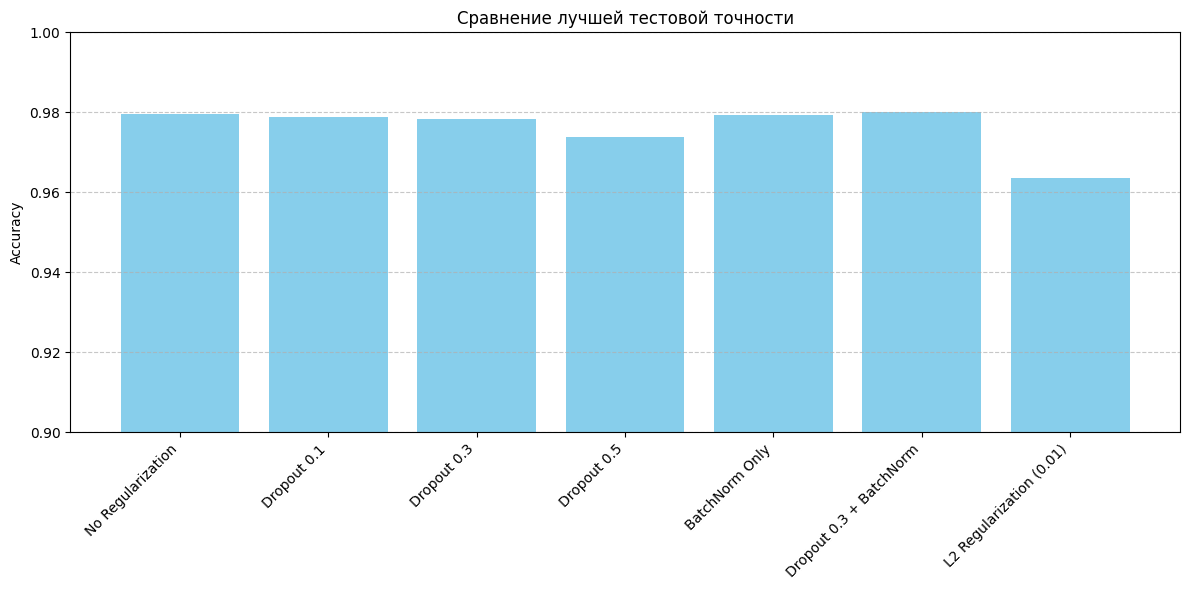

In [22]:
df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
plt.bar(df['name'], df['best_test_acc'], color='skyblue')
plt.title('Сравнение лучшей тестовой точности')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

У моделей без регуляризации, с дропаут 0.1, 03 и 05, с batchNorm и с дропаут 0.3 + batchNorm примерно одинаковая точность. Модель с дропаут 0.3 + batchNorm имеет наибольшую точность. Хуже всех имеет точность модель с l2 регуляризацией

<h3> Анализ стабильности

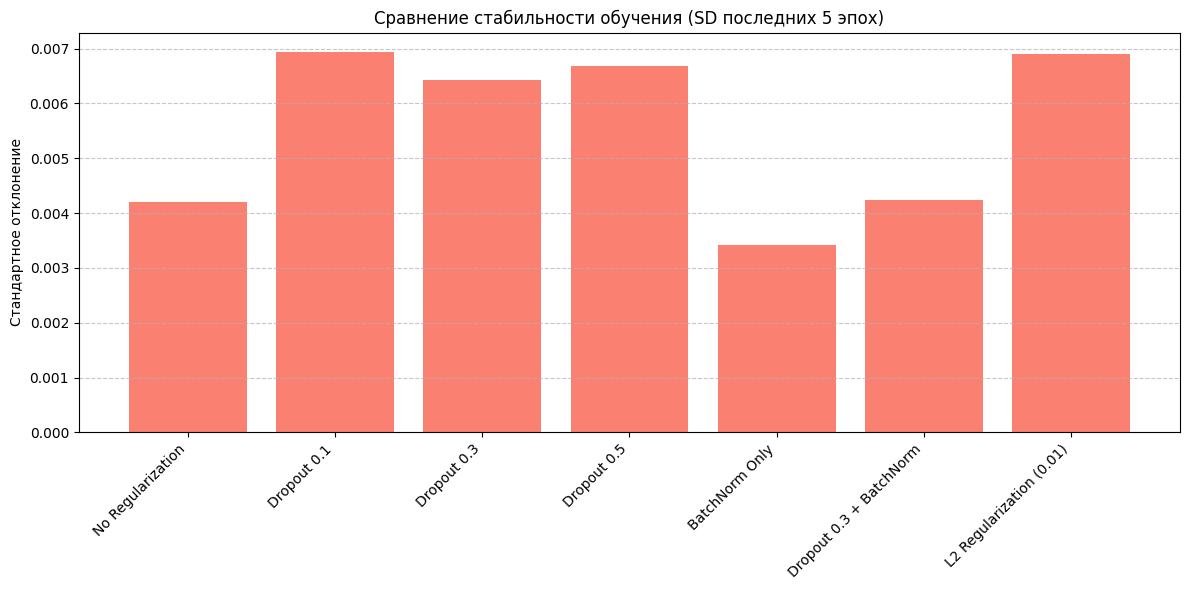

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(df['name'], df['stability'], color='salmon')
plt.title('Сравнение стабильности обучения (SD последних 5 эпох)')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Лучшая стабильность у модели с BatchNorm. У остальных моделей умеренная стабильность. 

<h3>Распределение весов

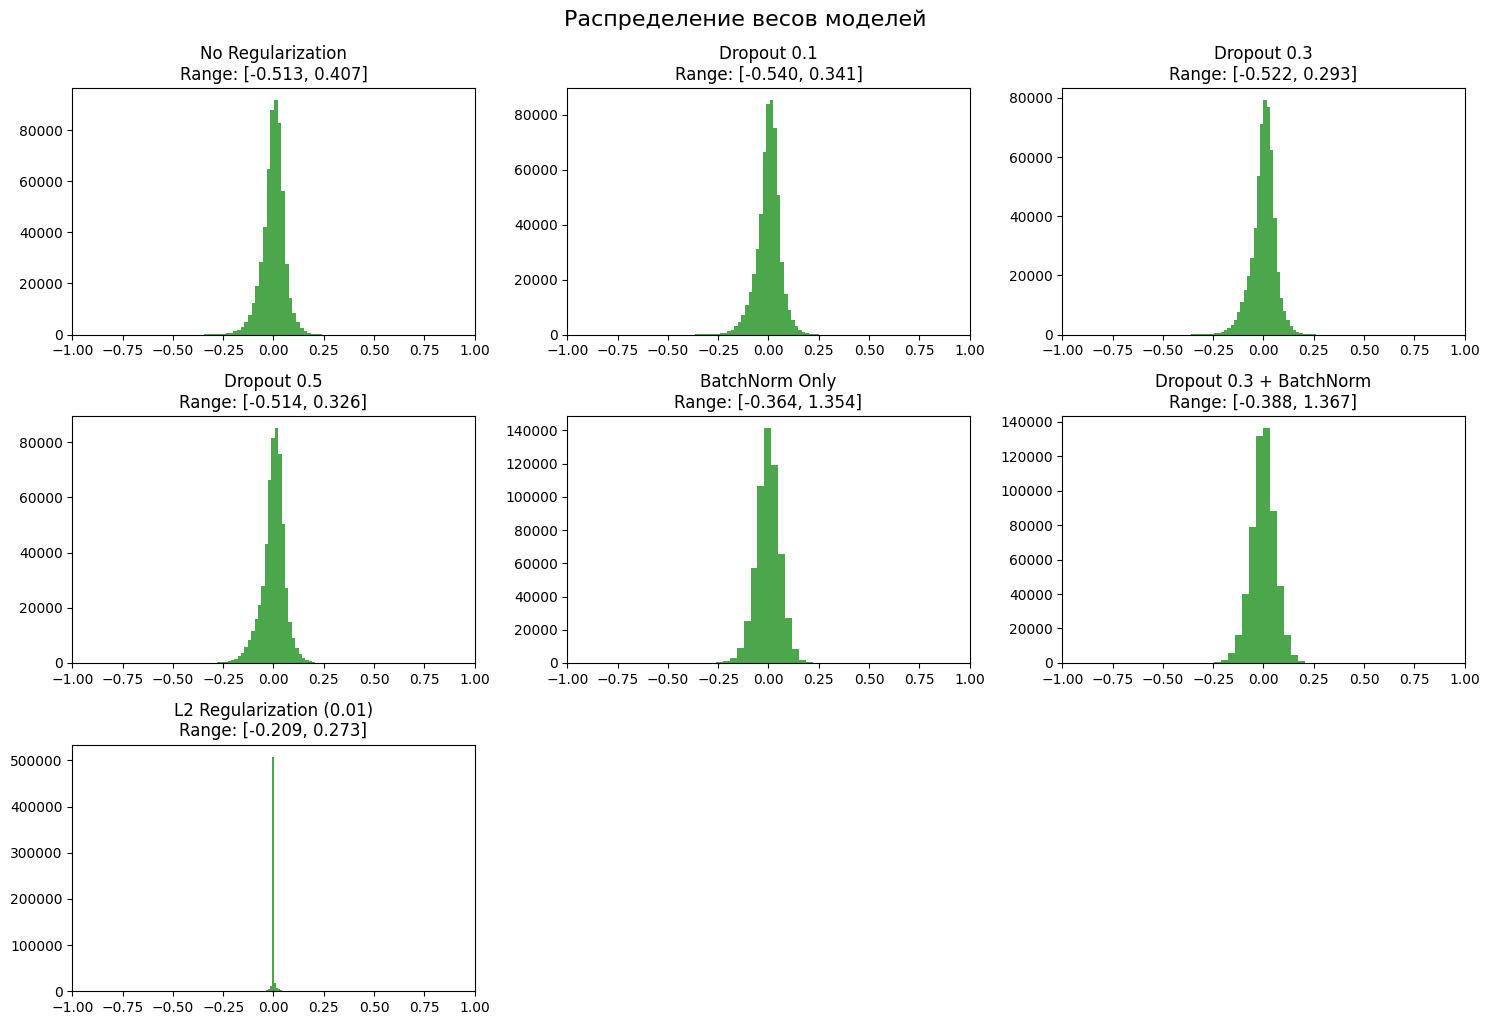

In [20]:
plt.figure(figsize=(15, 10))
for i, res in enumerate(results):
    plt.subplot(3, 3, i+1)
    plt.hist(res['weights'], bins=50, alpha=0.7, color='green')
    plt.title(f"{res['name']}\nRange: [{res['weights'].min():.3f}, {res['weights'].max():.3f}]")
    plt.xlim(-1, 1)
plt.tight_layout()
plt.suptitle('Распределение весов моделей', y=1.02, fontsize=16)
plt.show()

### 3.2 Адаптивная регуляризация (10 баллов)
```python
# Реализуйте адаптивные техники:
# - Dropout с изменяющимся коэффициентом
# - BatchNorm с различными momentum
# - Комбинирование нескольких техник
# - Анализ влияния на разные слои сети
```

In [43]:
class AdaptiveDropout(nn.Module):
    """Dropout с изменяемым коэффициентом во время обучения"""
    def __init__(self, base_rate=0.5, schedule='constant', max_epochs=100, **kwargs):
        super().__init__()
        self.base_rate = base_rate
        self.schedule = schedule
        self.max_epochs = max_epochs
        self.current_rate = base_rate
        self.dropout = nn.Dropout(base_rate)
        
        # Параметры для расписаний
        self.final_rate = kwargs.get('final_rate', 0.8)
        self.step_epochs = kwargs.get('step_epochs', 10)
        self.gamma = kwargs.get('gamma', 0.9)

    def update(self, epoch):
        """Обновление коэффициента dropout в зависимости от эпохи"""
        if self.schedule == 'linear_increase':
            self.current_rate = self.base_rate + (self.final_rate - self.base_rate) * min(epoch / self.max_epochs, 1.0)
        elif self.schedule == 'cosine':
            self.current_rate = self.final_rate - (self.final_rate - self.base_rate) * (1 + math.cos(math.pi * epoch / self.max_epochs)) / 2
        elif self.schedule == 'step_decay':
            if epoch > 0 and epoch % self.step_epochs == 0:
                self.current_rate *= self.gamma
        self.dropout.p = self.current_rate

    def forward(self, x):
        return self.dropout(x)

class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs
        
        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)
        
        # Списки для отслеживания адаптивных слоев
        self.adaptive_dropouts = []
        self.bn_layers = []
        
        self.layers = self._build_layers()
    
    def load_config(self, config_path):
        with open(config_path, 'r') as f:
            return json.load(f)
    
    def _build_layers(self):
        layers = []
        prev_size = self.input_size
        
        layer_config = self.config.get('layers', [])
        
        for layer_spec in layer_config:
            layer_type = layer_spec['type']
            
            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size
                
            elif layer_type == 'relu':
                layers.append(nn.ReLU())
                
            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())
                
            elif layer_type == 'tanh':
                layers.append(nn.Tanh())
                
            elif layer_type == 'dropout':
                # Параметры адаптивного dropout
                rate = layer_spec.get('rate', 0.5)
                schedule = layer_spec.get('schedule', 'constant')
                max_epochs = layer_spec.get('max_epochs', 100)
                dropout_layer = AdaptiveDropout(
                    base_rate=rate,
                    schedule=schedule,
                    max_epochs=max_epochs,
                    final_rate=layer_spec.get('final_rate', 0.8),
                    step_epochs=layer_spec.get('step_epochs', 10),
                    gamma=layer_spec.get('gamma', 0.9)
                )
                layers.append(dropout_layer)
                self.adaptive_dropouts.append(dropout_layer)
                
            elif layer_type == 'batch_norm':
                momentum = layer_spec.get('momentum', 0.1)
                bn_layer = nn.BatchNorm1d(prev_size, momentum=momentum)
                layers.append(bn_layer)
                self.bn_layers.append(bn_layer)
                
            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))
        
        layers.append(nn.Linear(prev_size, self.num_classes))
        
        return nn.Sequential(*layers)
    
    def update_adaptive_params(self, epoch):
        """Обновление параметров адаптивных слоев"""
        for dropout_layer in self.adaptive_dropouts:
            dropout_layer.update(epoch)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

def create_model_from_config(config_path, input_size=None, num_classes=None):
    return FullyConnectedModel(config_path, input_size, num_classes)

In [46]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False, epoch=0):
    if is_test:
        model.eval()
    else:
        model.train()
        # Обновляем адаптивные параметры перед обучением
        if hasattr(model, 'update_adaptive_params'):
            model.update_adaptive_params(epoch)
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(
            model, train_loader, criterion, optimizer, device, is_test=False, epoch=epoch
        )
        test_loss, test_acc = run_epoch(
            model, test_loader, criterion, None, device, is_test=True, epoch=epoch
        )
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Current Dropout Rates: {[layer.current_rate for layer in model.adaptive_dropouts]}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }